STEP 1: Setting up API call to Fetch Movie Ratings 

In [0]:
import requests

# TMDb API key
api_key = "c91a624779434de227949de04d58a82e"

# Function to fetch movie data by title from TMDb API
def fetch_movie_data(movie_title):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie_title}"
    response = requests.get(url)
    
    # Check if request was successful
    if response.status_code == 200:
        data = response.json()
        # Check if there are results
        if data["results"]:
            return data["results"][0]  # Returning the first matching movie
        else:
            print(f"No results found for movie: {movie_title}")
            return None
    else:
        print("Error fetching data:", response.status_code)
        return None

# Test the function
movie_data = fetch_movie_data("Gladiator")
print(movie_data)


{'adult': False, 'backdrop_path': '/jhk6D8pim3yaByu1801kMoxXFaX.jpg', 'genre_ids': [28, 18, 12], 'id': 98, 'original_language': 'en', 'original_title': 'Gladiator', 'overview': 'In the year 180, the death of Emperor Marcus Aurelius throws the Roman Empire into chaos. Maximus is one of the Roman army\'s most capable and trusted generals, as well as a key advisor to the emperor. As Marcus\' devious son Commodus ascends to the throne, Maximus is sentenced to execution. He escapes but is captured by slave traders. Renamed "Spaniard" and forced to become a gladiator, Maximus must battle to the death against other men for the amusement of paying audiences.', 'popularity': 864.719, 'poster_path': '/ty8TGRuvJLPUmAR1H1nRIsgwvim.jpg', 'release_date': '2000-05-04', 'title': 'Gladiator', 'video': False, 'vote_average': 8.217, 'vote_count': 18577}


STEP 2: Converting  API Response to Spark DF

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Example list of movie titles to fetch
movie_titles = ["Gladiator", "The Shawshank Redemption", "The Godfather"]

# Fetch data for each movie and store it in a list
movies_data = []
for title in movie_titles:
    data = fetch_movie_data(title)
    if data:
        # Extract relevant fields and append to the list
        movie_info = Row(
            title=data["title"],
            tmdb_rating=data["vote_average"],
            vote_count=data["vote_count"],
            release_date=data["release_date"]
        )
        movies_data.append(movie_info)

# Convert list to Spark DataFrame
movie_df = spark.createDataFrame(movies_data)
movie_df.show()


+--------------------+-----------+----------+------------+
|               title|tmdb_rating|vote_count|release_date|
+--------------------+-----------+----------+------------+
|           Gladiator|      8.217|     18577|  2000-05-04|
|The Shawshank Red...|      8.707|     27134|  1994-09-23|
|       The Godfather|       8.69|     20600|  1972-03-14|
+--------------------+-----------+----------+------------+



**Step 3: Data Cleaning and Transformation**

In [0]:
from pyspark.sql.functions import col, lit

# Add a normalized rating column
movie_df = movie_df.withColumn("normalized_rating", col("tmdb_rating"))
movie_df.show()


+--------------------+-----------+----------+------------+-----------------+
|               title|tmdb_rating|vote_count|release_date|normalized_rating|
+--------------------+-----------+----------+------------+-----------------+
|           Gladiator|      8.217|     18577|  2000-05-04|            8.217|
|The Shawshank Red...|      8.707|     27134|  1994-09-23|            8.707|
|       The Godfather|       8.69|     20600|  1972-03-14|             8.69|
+--------------------+-----------+----------+------------+-----------------+



**Step 4: Save Data to Delta Lake**

In [0]:
# Define Delta Lake path
delta_path = "/mnt/delta/movie_ratings"

# Save DataFrame to Delta Lake in overwrite mode
movie_df.write.format("delta").mode("overwrite").save(delta_path)


Step 5: Query and Aggregate Data

In [0]:
# Load data from Delta Lake
movie_df = spark.read.format("delta").load(delta_path)

# Register DataFrame as a temporary SQL table
movie_df.createOrReplaceTempView("movie_ratings")

# Calculate average rating
average_rating_df = spark.sql("SELECT AVG(normalized_rating) AS avg_rating FROM movie_ratings")
average_rating_df.show()


+-----------------+
|       avg_rating|
+-----------------+
|8.537999999999998|
+-----------------+



Step 6: Visualize Ratings


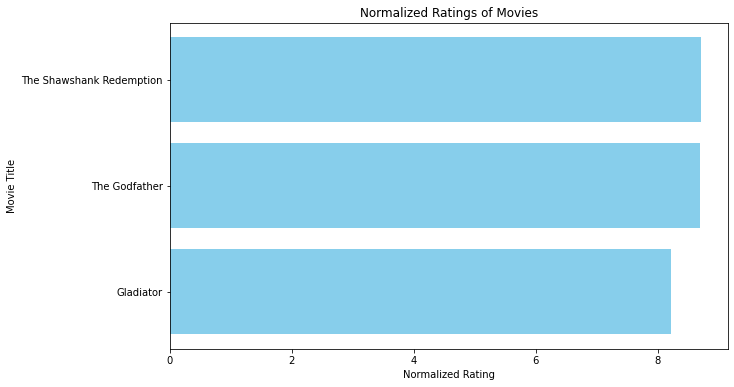

In [0]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas for easy plotting
movie_pd_df = movie_df.select("title", "normalized_rating").toPandas()

# Plotting the normalized ratings
plt.figure(figsize=(10, 6))
plt.barh(movie_pd_df["title"], movie_pd_df["normalized_rating"], color="skyblue")
plt.xlabel("Normalized Rating")
plt.ylabel("Movie Title")
plt.title("Normalized Ratings of Movies")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest rating at the top
plt.show()


In [0]:
import plotly.express as px

# Convert to Pandas DataFrame
movie_pd_df = movie_df.select("title", "tmdb_rating", "vote_count").toPandas()

# Create scatter plot
fig = px.scatter(
    movie_pd_df, 
    x="vote_count", 
    y="tmdb_rating", 
    hover_data=["title"], 
    title="TMDb Rating vs. Vote Count",
    labels={"vote_count": "Vote Count", "tmdb_rating": "TMDb Rating"},
)

fig.show()


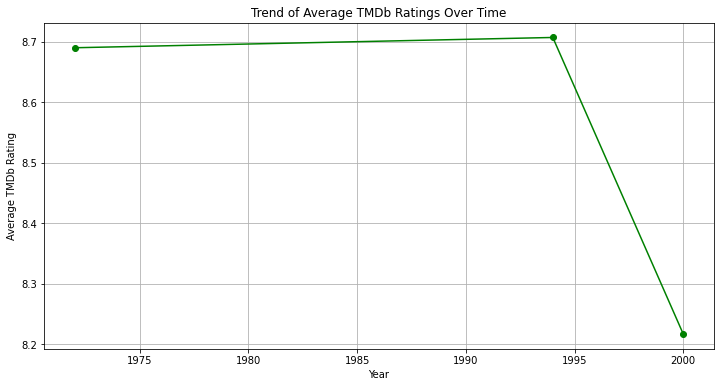

In [0]:
# Extract the year from the release date and calculate average rating by year
movie_df_with_year = movie_df.withColumn("year", col("release_date").substr(1, 4).cast("int"))
avg_rating_by_year = movie_df_with_year.groupBy("year").avg("tmdb_rating").orderBy("year").toPandas()

# Plot average rating trend over time
plt.figure(figsize=(12, 6))
plt.plot(avg_rating_by_year["year"], avg_rating_by_year["avg(tmdb_rating)"], marker="o", color="green")
plt.xlabel("Year")
plt.ylabel("Average TMDb Rating")
plt.title("Trend of Average TMDb Ratings Over Time")
plt.grid(True)
plt.show()
